<a href="https://colab.research.google.com/github/yananma/5_programs_per_day/blob/master/0504.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3.6 softmax 回归的从零开始实现

In [0]:
# !pip install mxnet d2lzh

In [0]:
%matplotlib inline 
import d2lzh as d2l  
from mxnet import autograd, nd 

In [0]:
batch_size = 256 
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [236]:
for X, y in train_iter:
    print(X.shape)
    print(y.shape)
    print(y[:10])
    break 

(256, 1, 28, 28)
(256,)

[1 4 2 6 1 3 8 7 6 3]
<NDArray 10 @cpu_shared(0)>


reinit 

In [0]:
num_inputs = 784 
num_outputs = 10 

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

In [0]:
W.attach_grad()
b.attach_grad()

In [256]:
X = nd.array([[1, 2, 3], [4, 5, 6]])
X.sum(axis=0, keepdims=True)


[[5. 7. 9.]]
<NDArray 1x3 @cpu(0)>

In [257]:
X.sum(axis=1, keepdims=True)


[[ 6.]
 [15.]]
<NDArray 2x1 @cpu(0)>

In [0]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition 

In [259]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(
 [[0.26479146 0.41922703 0.14376903 0.04618021 0.1260322 ]
  [0.08419192 0.1817623  0.24798082 0.28885728 0.19720767]]
 <NDArray 2x5 @cpu(0)>, 
 [0.99999994 1.        ]
 <NDArray 2 @cpu(0)>)

In [0]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b )

In [261]:
y_hat = nd.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = nd.array([0, 2], dtype='int32')
nd.pick(y_hat, y)


[0.1 0.5]
<NDArray 2 @cpu(0)>

In [0]:
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat, y).log()

In [0]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

In [264]:
accuracy(y_hat, y)

0.5

In [0]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0 
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size 
    return acc_sum / n 

In [0]:
import time 

num_epochs, lr = 5, 0.1 

train_ls, train_acc, test_acc_plot = [], [], []
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size 
            train_ls.append((l / y.size).asscalar())
            train_acc.append((y_hat.argmax(axis=1) == y).mean().asscalar())
        test_acc = evaluate_accuracy(test_iter, net)
        test_acc_plot.append(test_acc)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec' 
           % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc, time.time() - start))

In [267]:
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7881, train acc 0.749, test acc 0.801, time 8.4 sec
epoch 2, loss 0.5747, train acc 0.809, test acc 0.822, time 8.3 sec
epoch 3, loss 0.5296, train acc 0.824, test acc 0.830, time 8.2 sec
epoch 4, loss 0.5051, train acc 0.830, test acc 0.834, time 8.2 sec
epoch 5, loss 0.4896, train acc 0.835, test acc 0.839, time 8.1 sec


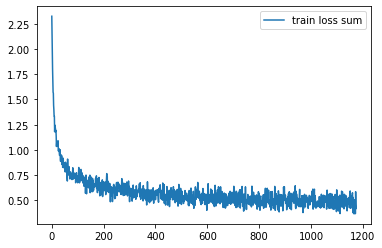

In [268]:
import matplotlib.pyplot as plt 

plt.plot(train_ls, label='train loss sum')
plt.legend()
plt.show()

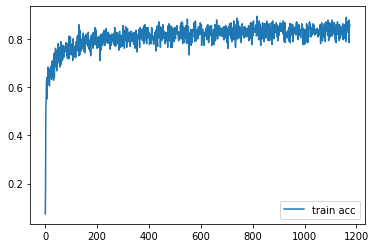

In [269]:
plt.plot(train_acc, label='train acc')
plt.legend()
plt.show()

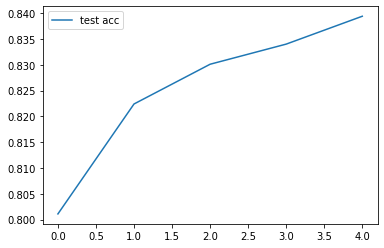

In [270]:
plt.plot(test_acc_plot, label='test acc')
plt.legend()
plt.show()

## 3.7 softmax 回归的简洁实现

In [0]:
%matplotlib inline  
import d2lzh as d2l 
from mxnet import gluon, init 
from mxnet.gluon import loss as gloss, nn 

In [0]:
batch_size = 256 
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [0]:
net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

In [0]:
loss = gloss.SoftmaxCrossEntropyLoss()

In [7]:
net.collect_params()

sequential0_ (
  Parameter dense0_weight (shape=(10, 0), dtype=float32)
  Parameter dense0_bias (shape=(10,), dtype=float32)
)

In [0]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [10]:
num_epochs = 5 
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, trainer)

epoch 1, loss 0.7888, train acc 0.746, test acc 0.805
epoch 2, loss 0.5745, train acc 0.811, test acc 0.824
epoch 3, loss 0.5287, train acc 0.824, test acc 0.834
epoch 4, loss 0.5045, train acc 0.830, test acc 0.832
epoch 5, loss 0.4892, train acc 0.834, test acc 0.840


In [11]:
net

Sequential(
  (0): Dense(784 -> 10, linear)
)

In [12]:
net.collect_params()

sequential0_ (
  Parameter dense0_weight (shape=(10, 784), dtype=float32)
  Parameter dense0_bias (shape=(10,), dtype=float32)
)

(256, 1, 28, 28)
(256,)


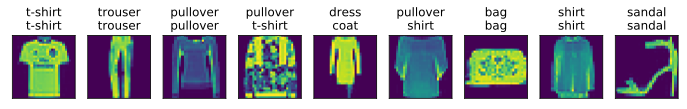

In [20]:
for X, y in test_iter:
    print(X.shape)
    print(y.shape)
    break 

true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[:9], titles[:9])